In [1]:
%load_ext rpy2.ipython

import sys 
import os
import math
import datetime
import os
import json
import re
import pprint
import pandas as pd
from subprocess import *
import subprocess
from importlib import reload  # Python 3.4+ only.
from IPython.display import Image

cwd = os.getcwd()
print(cwd)
# Adapt this path, it needs to point on the folder containing experiments/exptools.py.
sys.path.insert(1, os.path.abspath("."))
import analysis
reload(analysis)
from analysis import *


/home/adfaure/Projects/colmet_book/experiments/interferences/analysis


In [35]:
instances = [ 
    ExperimentInstance("../data/tcpkali_only_thesis_plot_periods30s/bb528c4c/"),
            ]

## Ip route on the routing node

```bash
g5k@paravance-1:~$ ip route
>default via 172.16.111.254 dev eno1
>10.158.0.0/22 dev eno1 proto kernel scope link src 10.158.0.1
>10.158.4.0/22 dev eno2 proto kernel scope link src 10.158.4.1
>172.16.96.0/20 dev eno1 proto kernel scope link src 172.16.96.1
```

## Ip route on a nodes of the subnetwork 10.158.0.0/22

```bash
10.158.0.2:# ip route
>10.158.0.0/22 dev eno2 proto kernel scope link src 10.158.0.2
>10.158.4.0/22 via 10.158.0.1 dev eno2
>172.16.96.0/20 dev eno1 proto kernel scope link src 172.16.96.1

```

## on 10.158.4.0/22

```bash
10.158.4.2:# ip route
>10.158.0.0/22 via 10.158.4.1 dev eno2
>10.158.4.0/22 dev eno2 proto kernel scope link src 10.158.4.2
>172.16.96.0/20 dev eno1 proto kernel scope link src 172.16.96.7

```

## Ip route on the routing node (simplified version)

```bash
g5k@paravance-1:# ip route
>10.158.0.0/22 dev eno1 proto kernel scope link src 10.158.0.1
>10.158.4.0/22 dev eno2 proto kernel scope link src 10.158.4.1
```

## Ip route on a nodes of the subnetwork 10.158.0.0/22
    
```bash
10.158.0.2:# ip route
>10.158.0.0/22 dev eno2 proto kernel scope link src 10.158.0.2
>10.158.4.0/22 via 10.158.0.1 dev eno2

```

## on 10.158.4.0/22

```bash
10.158.4.2:# ip route
>10.158.4.0/22 dev eno2 proto kernel scope link src 10.158.4.2
>10.158.0.0/22 via 10.158.4.1 dev eno2
```

# A tibble: 1,318 x 9
   timestamp cpu_cycles instructions   rxp   rxb   txp   txb X8    src         
       <dbl>      <dbl>        <dbl> <dbl> <dbl> <dbl> <dbl> <lgl> <chr>       
 1      3.47   13006948      1394310     0     0     0     0 NA    router (if0)
 2      4.46   70971183     25382284     5   390     2   464 NA    router (if0)
 3      5.46   21792121      4546891     0     0     0     0 NA    router (if0)
 4      6.46   20541297      4381852     0     0     0     0 NA    router (if0)
 5      7.46   23471045      5060548     1    60     0     0 NA    router (if0)
 6      8.46   19557585      4175149     0     0     0     0 NA    router (if0)
 7      9.46  264034986    219680414    47 12325    45 12192 NA    router (if0)
 8     10.5    67398589     18122227    35  9346    31  9367 NA    router (if0)
 9     11.5    24350770      4790014     0     0     0     0 NA    router (if0)
10     12.5    21424587      4382566     0     0     0     0 NA    router (if0)
# … with 1,308 mor

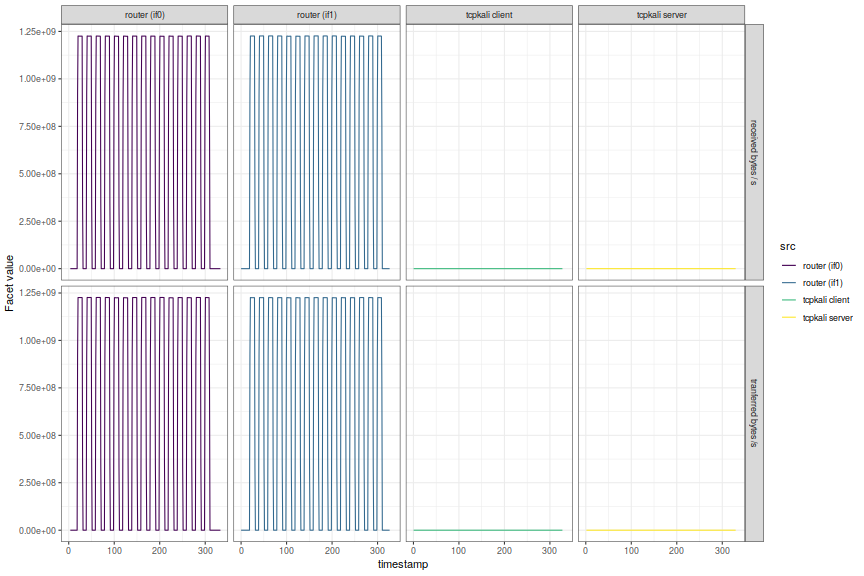

In [19]:
%%R -w 12 -h 8 --units in
library(tidyverse)
library(viridis)

instance = "../data/tcpkali_only_thesis_plot/bd97edf0/"

test =  read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router (if0)") %>% 
        bind_rows( read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "router (if1)")) %>% 
        bind_rows( read_table2(paste0(instance, "paravance-10.rennes.grid5000.fr.eno1.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client") ) %>% 
        bind_rows( read_table2(paste0(instance, "paravance-7.rennes.grid5000.fr.eno1.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali server")) %>% mutate(timestamp = timestamp - min(timestamp))

print(test)
test %>% select(timestamp, src, txb, rxb) %>% rename("tranferred bytes /s " = txb, "received bytes / s" = rxb) %>% gather(col, val, -src, -timestamp) %>% ggplot(aes(x = timestamp, y = val, colour = src)) + 
    ylab("Facet value") + 
    geom_line(aes(markers = src)) + facet_grid(col~src) + theme_bw() + 
    scale_colour_viridis_d() + ggsave("/tmp/plot.pdf")

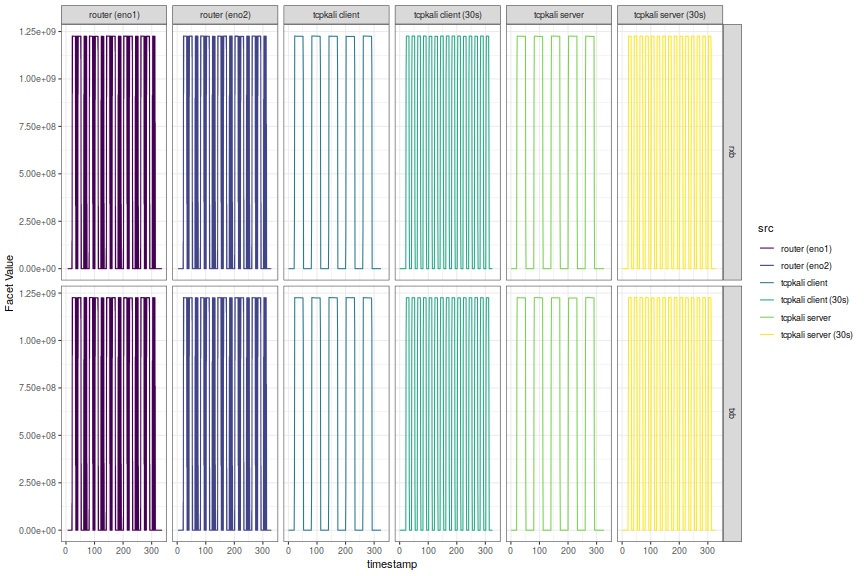

In [31]:
%%R -w 12 -h 8 --units in
library(tidyverse)
library(viridis)

instance = "../data/tcpkali_only_thesis_plot_periods30s/bb528c4c/"

tensec =  read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router (eno1)") %>% 
        bind_rows( read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "router (eno2)")) %>% 
        bind_rows( read_table2(paste0(instance, "paravance-10.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client") ) %>% 
        bind_rows( read_table2(paste0(instance, "paravance-7.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali server")) %>% mutate(timestamp = timestamp - min(timestamp))

instance = "../data/tcpkali_only_thesis_plot/bd97edf0/"
thirtysec =  read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
         rename(timestamp = "#timestamp") %>% mutate(src = "router (eno1)") %>% 
         bind_rows( read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
         rename(timestamp = "#timestamp") %>% mutate(src = "router (eno2)")) %>% 
         bind_rows( read_table2(paste0(instance, "paravance-10.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
         rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client (30s)") ) %>% 
         bind_rows( read_table2(paste0(instance, "paravance-7.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
         rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali server (30s)")) %>% mutate(timestamp = timestamp - min(timestamp))


bind_rows(tensec, thirtysec) %>% select(txb, rxb, timestamp, src) %>% gather(col, val, -timestamp, -src) %>% 
    ggplot(aes(x = timestamp, y = val, color = src)) + 
    ylab("Facet Value") + 
    geom_line(aes()) + facet_grid(col~src) + theme_bw() + 
    scale_colour_viridis_d()

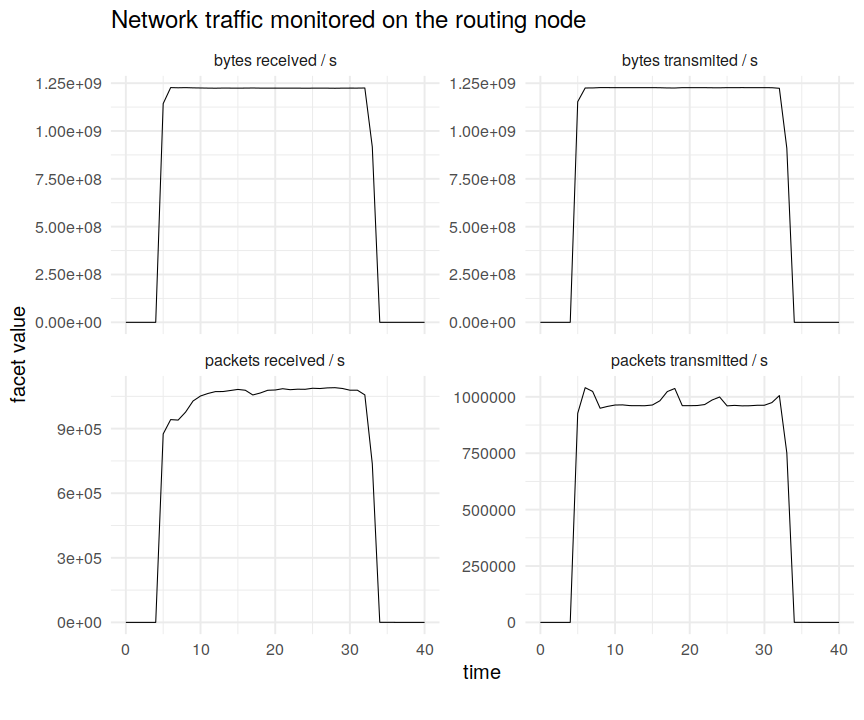

In [70]:
%%R -w 12 -h 10 --units in
library(tidyverse)
library(viridis)

m3 = read_table2("../data/tcpkali_configurations_test/small_messages_2hosts.csv") %>%
  mutate(timestamp =  timestamp - min(timestamp)) %>%
  rename("bytes transmited / s" = txb,
         "bytes received / s" = rxb,
         "packets transmitted / s" = txp,
         "packets received / s" = rxp)

m3 <- m3 %>% gather(col, val, -timestamp)

m3 %>% ggplot(aes(x = timestamp, y = val)) +
  geom_line() +
  facet_wrap(. ~col, scales = "free_y") +
  xlab("time") + ylab("facet value") + labs(title ="Network traffic monitored on the routing node", caption  = "") +
  theme(plot.caption = element_text(hjust = 0, face= "italic")) +
  theme_minimal(base_size = 20)  + 
  ggsave("/home/adfaure/Projects/Thesis/img/facet_tcpkali.pdf", height = 8)

/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Parsed with column specification:
cols(
  `#timestamp` = col_double(),
  cpu_cycles = col_double(),
  instructions = col_double(),
  rxp = col_double(),
  rxb = col_double(),
  txp = col_double(),
  txb = col_double(),
  X8 = col_logical()
)

  warnings.warn(x, RRuntimeWarning)
/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Saving 12 x 8 in image

  warnings.warn(x, RRuntimeWarning)


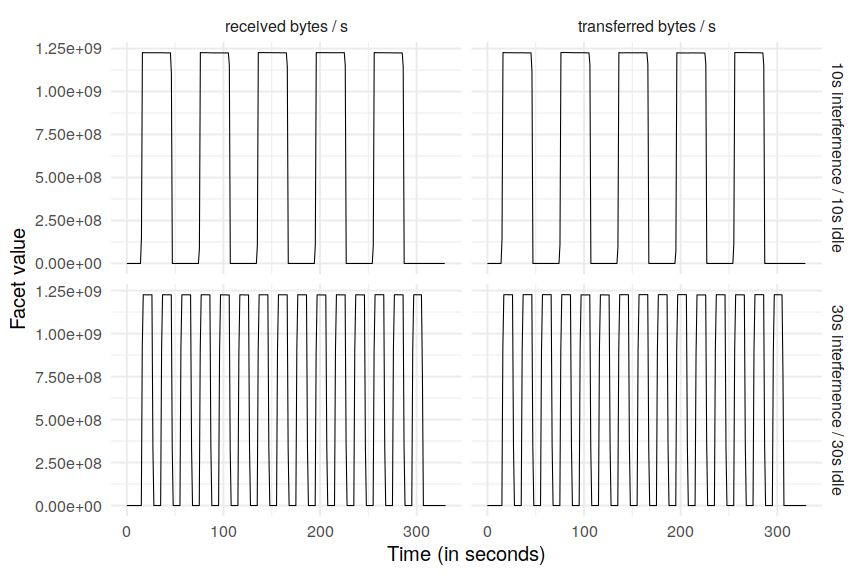

In [67]:
%%R -w 12 -h 8 --units in
library(tidyverse)
library(viridis)


instance = "../data/tcpkali_only_thesis_plot_periods30s/bb528c4c/"

tensec = read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
         rename(timestamp = "#timestamp") %>% mutate(src = "10s interfernence / 10s idle", timestamp = timestamp - min(timestamp))
        
instance  = "../data/tcpkali_only_thesis_plot/bd97edf0/"
thirtysec =  read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
         rename(timestamp = "#timestamp") %>% mutate(src = "30s interfernence / 30s idle", timestamp = timestamp - min(timestamp))


data = bind_rows(tensec, thirtysec) %>% 
    select(txb, rxb, timestamp, src)  %>% rename("transferred bytes / s" = txb, "received bytes / s" = rxb) %>%
    gather(col, val, -timestamp, -src)
    
ggplot(data, aes(x = timestamp, y = val)) + 
    geom_line(aes()) +  facet_grid(src~col) + 
    theme_minimal(base_size = 22) +  ylab("Facet value") + xlab("Time (in seconds)") +
    ggsave("/home/adfaure/Projects/Thesis/img/facet_tcpkali_period_types.pdf")